## 0. **필요 라이브러리 호출**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from functools import reduce
import matplotlib.patches as mpatches

## 1. **데이터 로드 및 전처리**

In [78]:
# 데이터 로드
df = pd.read_csv("store_game_summary_normalized.csv", encoding="cp949")
games_df = pd.read_csv("games_of_month.csv", encoding="utf-8-sig")
games_of_month = games_df["게임명"].dropna().str.strip().tolist()

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.ttf"

# 부분 포함 여부 판단 함수
def contains_all_keywords(game_list, keywords):
    return all(any(keyword in game for game in game_list) for keyword in keywords)

# 문자열을 리스트로 변환
def parse_game_list(game_str):
    if pd.isna(game_str):
        return []
    return [game.strip() for game in game_str.split(";")]

# 전체 지점에 대해 게임 보유 여부 컬럼 추가
df["이달의게임_보유_여부"] = df["보유 게임 목록"].apply(
    lambda x: contains_all_keywords(parse_game_list(x), games_of_month)
)

# 특정 지점의 미보유 게임 리스트 반환 함수
def get_missing_games(game_str, target_games):
    owned_games = parse_game_list(game_str)
    missing = [g for g in target_games if not any(g in owned for owned in owned_games)]
    return missing

# 새 컬럼 추가
df["이달의게임_미보유_리스트"] = df["보유 게임 목록"].apply(
    lambda x: get_missing_games(x, games_of_month)
)

# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "서울"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]

In [80]:
region_df.head()

,지역,지점명,보유 게임 수,미보유 게임 수,보유 게임 목록,미보유 게임 목록,이달의게임_보유_여부,이달의게임_미보유_리스트,지역_지점
0,서울,신촌,408,601,"13클루, 5분던전, 5분마블, 5초준다, OX퀴즈왕, 가짜예술가 뉴욕에가다, 간장...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],서울 - 신촌
1,서울,신림,362,647,"5분마블, 5초준다, 가짜예술가 뉴욕에가다, 갈팡질팡, 강아지똥, 강아지똥 웰시코기...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 13클루, 3초 트라이, ...",True,[],서울 - 신림
2,서울,대학로,422,587,"13클루, 5분던전, 5분마블, 5초준다, OX퀴즈왕, 가짜예술가 뉴욕에가다, 간장...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],서울 - 대학로
3,서울,강남,398,611,"13클루, 5분마블, 5초준다, OX퀴즈왕, 가짜예술가 뉴욕에가다, 간장공장공장장,...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],서울 - 강남
4,서울,노원,343,666,"13클루, 5분마블, 5초준다, 가짜예술가 뉴욕에가다, 갈팡질팡, 강아지똥 웰시코기...","1%의 기적, 10일간의 미국여행, 10일간의 유럽여행, 3초 트라이, 5분 미스터...",True,[],서울 - 노원


In [100]:
df[df["이달의게임_보유_여부"] == False][["지역", "지점명", "이달의게임_미보유_리스트"]]

,지역,지점명,이달의게임_미보유_리스트
31,경기,영통,[금지어 게임]
38,경기,용인동백,"[금지어 게임, 라쿠카라차]"
40,경기,수원인계,[라쿠카라차]
45,경기,김포구래,[라쿠카라차]
50,경기,평택소사벌,"[라이헌트, 금지어 게임]"
61,인천,구월,[라쿠카라차]
74,대구,광장코아,[라쿠카라차]
102,제주,제주시청,[라쿠카라차]


## 2. **시각화**

### **2-1. 막대 차트 - 보유/미보유 게임 수 막대 그래프 (Top 5 지점)**

#### **(1) 누적 막대 차트**

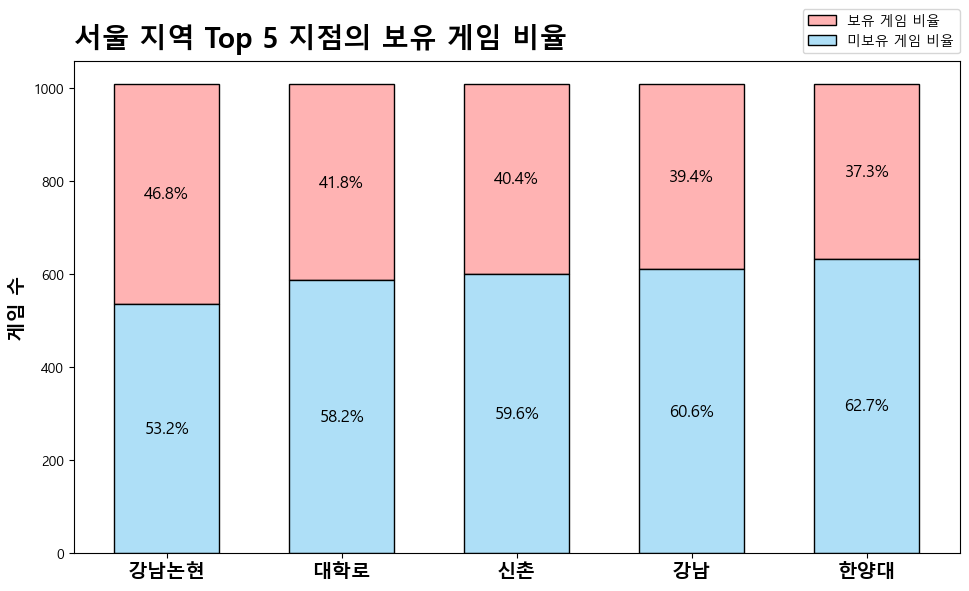

In [9]:
# Top 5 보유 지점
top5 = region_df.sort_values(by='보유 게임 수', ascending=False).head(5).reset_index(drop=True)

# 5개 미만 시 빈 막대 추가
while len(top5) < 5:
    top5 = pd.concat([top5, pd.DataFrame([{
        '지점명': '',
        '보유 게임 수': 0,
        '미보유 게임 수': 0
    }])], ignore_index=True)

# 누적 막대차트 생성
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(top5))
bar_width = 0.6

# 비율 계산
top5["총 게임 수"] = top5["보유 게임 수"] + top5["미보유 게임 수"]
top5["보유 비율"] = (top5["보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)
top5["미보유 비율"] = (top5["미보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)

# 색상 설정
colors = {
    '보유': '#FFB3B3',     # 연한 붉은색
    '미보유': '#AEDFF7'    # 연한 하늘색
}

# 막대 그리기 + 테두리
bar1 = ax.bar(x, top5['보유 게임 수'], width=bar_width, color=colors['보유'],
              bottom=top5['미보유 게임 수'], edgecolor='black', label='보유 게임 비율')
bar2 = ax.bar(x, top5['미보유 게임 수'], width=bar_width, color=colors['미보유'],
              edgecolor='black', label='미보유 게임 비율')

# 비율 텍스트 표시
for i in range(len(top5)):
    if top5["지점명"][i] != "":
        ax.text(x[i], top5['미보유 게임 수'][i] / 2,
                f"{top5['미보유 비율'][i]:.1f}%", ha='center', va='center', fontsize=12, color='black')
        ax.text(x[i], top5['미보유 게임 수'][i] + top5['보유 게임 수'][i] / 2,
                f"{top5['보유 비율'][i]:.1f}%", ha='center', va='center', fontsize=12, color='black')

# X축 설정
ax.set_xticks(x)
ax.set_xticklabels(top5['지점명'], fontsize=14, fontweight="bold")

# 타이틀 (좌측 정렬)
ax.set_title(f"{selected_region} 지역 Top 5 지점의 보유 게임 비율",
             fontsize=20, fontweight="bold", loc='left', pad=10)

# y축 레이블
ax.set_ylabel("게임 수", fontsize=14, fontweight="bold")

# 범례 (타이틀 오른쪽 우상단 위치)
ax.legend(loc='center left', bbox_to_anchor=(0.815, 1.06), fontsize=10)

fig.tight_layout()
plt.show()

#### **(2) 묶은 막대 차트**

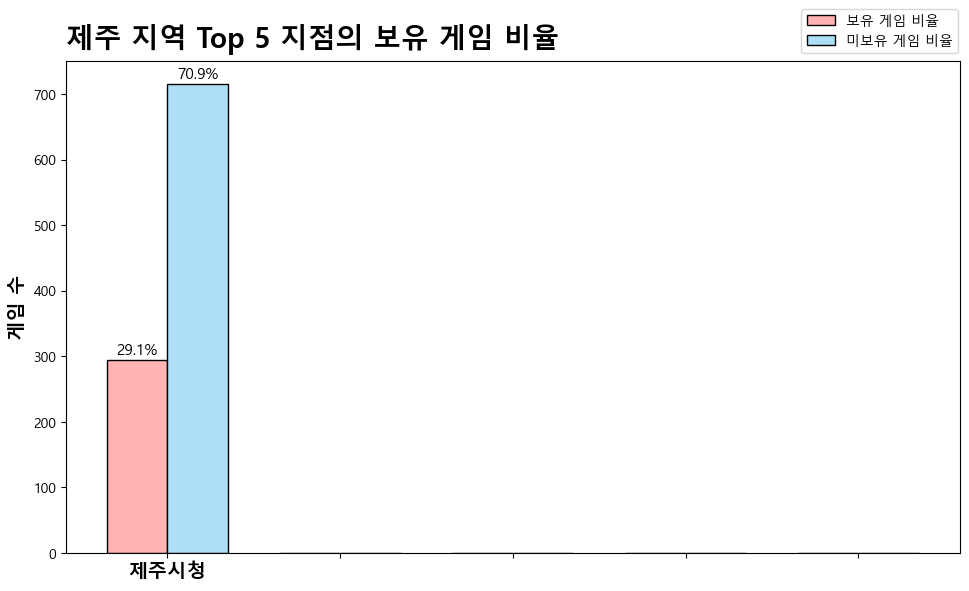

In [ ]:
# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "제주"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]



# Top 5 보유 지점
top5 = region_df.sort_values(by='보유 게임 수', ascending=False).head(5).reset_index(drop=True)

# 5개 미만 시 빈 막대 추가
while len(top5) < 5:
    top5 = pd.concat([top5, pd.DataFrame([{
        '지점명': '',
        '보유 게임 수': 0,
        '미보유 게임 수': 0
    }])], ignore_index=True)

# 차트 생성
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(top5))
bar_width = 0.35  # 각 막대 너비 줄이기

# 비율 계산
top5["총 게임 수"] = top5["보유 게임 수"] + top5["미보유 게임 수"]
top5["보유 비율"] = (top5["보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)
top5["미보유 비율"] = (top5["미보유 게임 수"] / top5["총 게임 수"] * 100).fillna(0)

# 색상 설정
colors = {
    '보유': '#FFB3B3',
    '미보유': '#AEDFF7'
}

# 묶은 막대 그리기
bar1 = ax.bar(x - bar_width/2, top5['보유 게임 수'], width=bar_width,
              color=colors['보유'], edgecolor='black', label='보유 게임 비율')
bar2 = ax.bar(x + bar_width/2, top5['미보유 게임 수'], width=bar_width,
              color=colors['미보유'], edgecolor='black', label='미보유 게임 비율')

# 비율 텍스트 표시 (각 막대 위에 표시)
for i in range(len(top5)):
    if top5["지점명"][i] != "":
        ax.text(x[i] - bar_width/2, top5['보유 게임 수'][i] + 3,
                f"{top5['보유 비율'][i]:.1f}%", ha='center', va='bottom', fontsize=11)
        ax.text(x[i] + bar_width/2, top5['미보유 게임 수'][i] + 3,
                f"{top5['미보유 비율'][i]:.1f}%", ha='center', va='bottom', fontsize=11)

# X축 설정
ax.set_xticks(x)
ax.set_xticklabels(top5['지점명'], fontsize=14, fontweight="bold")

# 타이틀 (좌측 정렬)
ax.set_title(f"{selected_region} 지역 Top 5 지점의 보유 게임 비율",
             fontsize=20, fontweight="bold", loc='left', pad=10)

# y축 레이블
ax.set_ylabel("게임 수", fontsize=14, fontweight="bold")

# 범례 (타이틀 오른쪽 우상단)
ax.legend(loc='center left', bbox_to_anchor=(0.815, 1.06), fontsize=10)

fig.tight_layout()
plt.show()

# 차트 저장
file_name = f"C:/Users/am001/teamProject1/static/charts/{selected_region} 막대 차트.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')

---
### **2-2. 워드클라우드 - 선택 지점 전체 보유 게임**

#### **(1) 지역 고유 보드게임 워드클라우드**

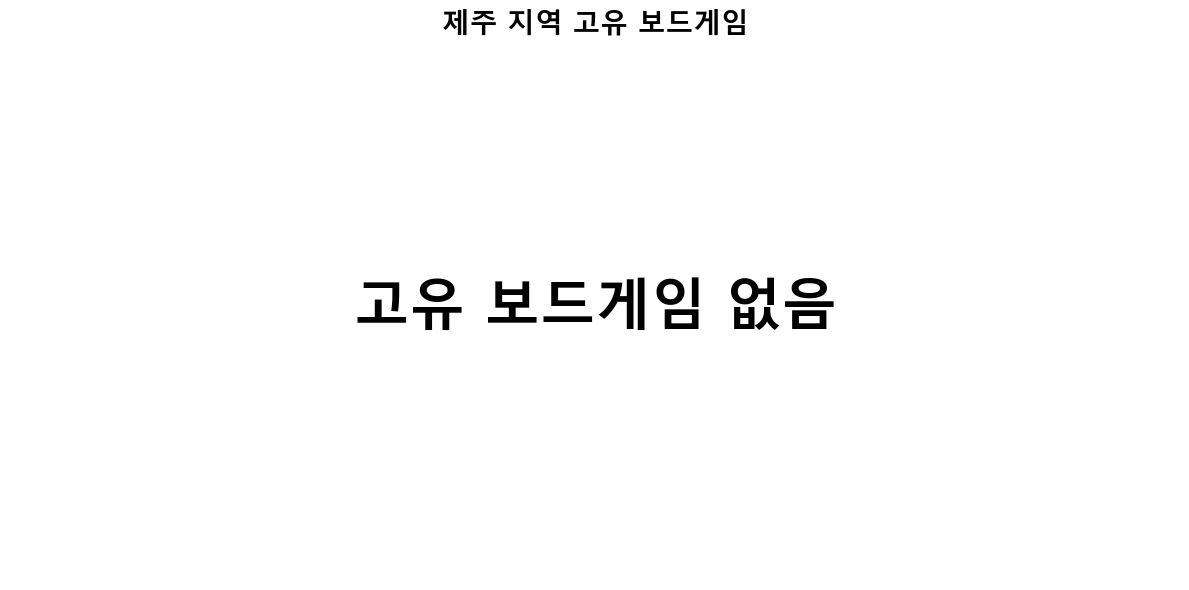

In [214]:
# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "제주"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]



# 선택 지역과 타 지역으로 분리
region_df = df[df["지역"] == selected_region].copy()
other_df = df[df["지역"] != selected_region].copy()

# 각 지역의 보유 게임 set 추출
def extract_games(df):
    return set(
        game.strip()
        for games in df["보유 게임 목록"].dropna()
        for game in games.split(',')
        if game.strip() != ''
    )

region_games = extract_games(region_df)
other_games = extract_games(other_df)

# 고유 게임 = 선택 지역에서만 등장하는 게임
unique_games = region_games - other_games

# 고유 게임이 존재하면: 해당 게임이 지역 내 몇 개 지점에서 보유되고 있는지 count
if unique_games:
    game_counter = Counter()
    for games in region_df["보유 게임 목록"].dropna():
        game_list = [g.strip() for g in games.split(',')]
        for game in game_list:
            if game in unique_games:
                game_counter[game] += 1

    word_freq = dict(game_counter)

    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white',
        random_state=42
    ).generate_from_frequencies(word_freq)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"{selected_region} 지역 고유 보드게임", fontsize=20, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # 이미지 저장
    wordcloud.to_file(f"{selected_region} 워드클라우드.png")

else:
    # 고유 보드게임이 없을 경우 → 텍스트 수동 표시
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.text(0.5, 0.5, "고유 보드게임 없음", fontsize=40, fontweight="bold",
            ha='center', va='center', fontname='Malgun Gothic')
    ax.axis("off")
    ax.set_title(f"{selected_region} 지역 고유 보드게임", fontsize=20, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # 이미지 저장 (워드클라우드가 아닌 fig 자체 저장)
    fig.savefig(f"{selected_region} 워드클라우드.png", dpi=300)

### **2-3. 히트맵 - 보유/미보유 게임 수**

#### **(1) 히트맵**

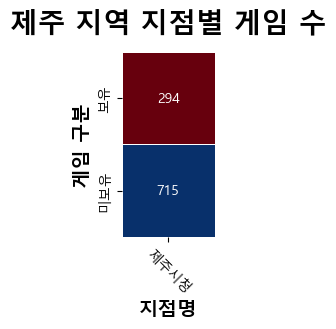

In [238]:
# 사용자로부터 선택된 지역 (웹 연동 시 query param 또는 form 값으로 전달됨)
selected_region = "제주"  # 예시 지역 (웹에선 동적으로 바뀔 것)

# 지역 필터링
region_df = df[df["지역"] == selected_region].copy()
region_df["지역_지점"] = region_df["지역"] + " - " + region_df["지점명"]



# pivot 및 정렬
pivot = region_df[["지점명", "보유 게임 수", "미보유 게임 수"]].set_index("지점명").T
pivot.index = ["보유", "미보유"]
pivot = pivot.loc[:, pivot.loc["보유"].sort_values(ascending=False).index]

# 값 범위
vmin_b = pivot.loc["보유"].min() * 0.9  # 또는 -10, 0 등으로 고정
vmax_b = pivot.loc["보유"].max()

# 예: 미보유 기준
vmin_m = pivot.loc["미보유"].min() * 0.9
vmax_m = pivot.loc["미보유"].max()

# 마스크 생성 함수
def get_row_mask(df, target_row_label):
    return pd.DataFrame(
        [[row != target_row_label for _ in df.columns] for row in df.index],
        index=df.index,
        columns=df.columns
    )

mask_boyu = get_row_mask(pivot, "보유")
mask_miboyu = get_row_mask(pivot, "미보유")

# 셀당 크기를 기준으로 정사각형 유지
cell_size = 1.2
fig_width = len(pivot.columns) * cell_size
fig_height = len(pivot.index) * cell_size

fig3, ax3 = plt.subplots(figsize=(fig_width, fig_height))

# 1. 보유: 파랑 계열
sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt=".0f",
            ax=ax3, cbar=False, mask=mask_boyu, vmin=vmin_b, vmax=vmax_b)

# 2. 미보유: 빨강 계열
sns.heatmap(pivot, cmap="Blues", linewidths=0.5, annot=True, fmt=".0f",
            ax=ax3, cbar=False, mask=mask_miboyu, vmin=vmin_m, vmax=vmax_m)

# 라벨
ax3.set_title(f"{selected_region} 지역 지점별 게임 수", fontsize=20, fontweight="bold", pad=15)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=-45, fontsize=10)
ax3.set_xlabel("지점명", fontsize=14, fontweight="bold")
ax3.set_ylabel("게임 구분", fontsize=14, fontweight="bold")

plt.show()

# 차트 저장
file_name = f"{selected_region} 히트맵.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')

### **2-4. 파이 차트 - 이달의 게임 보유/미보유 지점 수**

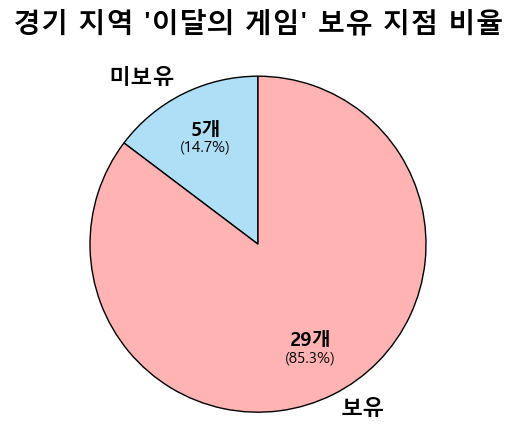

In [158]:
# 색상 설정
colors = ["#AEDFF7", "#FFB3B3"]

# 전체 개수 계산
total = len(region_df)
true_count = region_df["이달의게임_보유_여부"].sum()
false_count = total - true_count
sizes = [false_count, true_count]
labels = ["미보유", "보유"]

# 파이차트 그리기 (autopct은 제거)
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    sizes,
    labels=labels,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# 중심 좌표 계산 및 개수/퍼센트 텍스트 수동 배치
for i, wedge in enumerate(wedges):
    if sizes[i] == 0:
        continue  # 0이면 아무 것도 표시 안함
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    # 중심 위치 보정
    x_text = 0.7 * x
    y_text = 0.7 * y

    # 개수 텍스트 (위, 크게, 볼드)
    count = sizes[i]
    ax.text(
        x_text,
        y_text + 0.05,  # 위쪽
        f"{count}개",
        ha='center',
        va='center',
        fontsize=14,
        weight='bold'
    )

    # 비율 텍스트 (아래, 기본)
    pct = count / sum(sizes) * 100
    ax.text(
        x_text,
        y_text - 0.05,  # 아래쪽
        f"({pct:.1f}%)",
        ha='center',
        va='center',
        fontsize=11
    )

# 라벨 폰트 조정
for text in texts:
    text.set_fontsize(16)
    text.set_weight("bold")

ax.axis("equal")
plt.title(f"{selected_region} 지역 '이달의 게임' 보유 지점 비율", fontsize=20, fontweight="bold", pad=20)
plt.show()